# STEP_dask Tutorial Notebook

### Intro 

This package is a reimplementation of the Storm Tracking and Evaluation Protocol (STEP) package originally developed by Alex Rittler. The original STEP can be found here (https://github.com/RDCEP/STEP).

The goal for STEP_dask is to increase the efficiency of STEP so that large datasets on the order of several million cells may be analyzed.

### Overview

Several key changes have been made to the tracking function that increases single-threaded and multi-worker performance. We'll first go over how the original STEP handled this, and then discuss what has been changed.

### Original Tracking Methodology

At its core, STEP relied on two for loops to do the brunt of the work. The outer for loop went through every uniquely labeled storm in the current timestep. The second for loop, nested within the first, went through every uniquely labeled storm in the previous timestep.

Within the nested loop, the following steps would be taken to determine whether the two storms matched:

1. Check to see if the previous storm is larger than the next best match
2. If so, calculate the morphological similarity of the two storms 
3. If the similarity passes a pre-defined threshold, two calculations are performed to determine if the storm is a match candidate:
        a. Calculate the displacement between the two storm centroids
        b. Calculate the displacement vector of the previous storm and the current storm
4. If either criteria meets some threshold, the storm is considered the best match and moves on to the next item in the loop

### Major Changes


1. Reworking the similarity index

        Profiling STEP reveals that a majority of the computational time is spent calculating the morphological similarity. This is handled by the function "similarity" found here: https://github.com/RDCEP/STEP/blob/master/step/tracking.py.

        Within this function, a 2D array is created with each dimension having a size equal to the combined total cell count of the two storms being compared. So, a comparison of two storms of size 50 and 100 would yield a 150x150 array. This can easily be handled within numpy, and any calculations done on this array are very quick.

        However, when storm sizes increase, such as in cases where the grid spacing is very fine or the considered region is large, this calculation uses a lot of memory and becomes computationally expensive. For instance, two storms with sizes of 6,000 and 7,000 result in an array with dimensions of 13,000 x 13,000. This computation may take a few seconds to run in numpy, but this can really add up in cases like this where nested for loops are involved. 
        
        To get around this, the similarity function is reworked to chunk up the array and only load each chunk into memory when performing the computation. This speeds up single-threaded performance and drastically reduces the amount of memory needed. 
        
2. Changing the order of when calculations are called

        In the modified function, the order of the calculations are altered to reduce the amount of times the similairity function needs to be called.
        
        The order now is:
        
        1. Calculate the centroid displacement & displacement angle between the two storms (this is fairly quick and can be done entirely in memory using numpy)
        2. If either passes the criteria, calculate the similarity of the two storms
        3. The selected match is then identified as the largest storm that passes the similarity threshold
        
        Both this and the change above resulted in computation time less than half that of the original!
        
3. Turn the for loops into dask delayed objects

        The most significant change takes advantage of dask to simultaneously calculate all possible outcomes from the for loop at once without having to wait for the prior result to be finished.
        
        These jobs are then called in and computed in batches of 2,500 to reduce the amount of tasks that are sent to the dask scheduler. The result is a near-linear reduction in the amount of time it takes to run STEP as computational power is increased.
        

## Sample notebook workflow

Below is a sample of how to setup and run STEP_dask

In [2]:
import identification as idf
import tracking as tr
import dask_tracking

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime, timedelta, date

from skimage import draw
import copy

from math import sqrt
import numpy as np
from scipy.ndimage.measurements import center_of_mass
from scipy.spatial.distance import pdist, squareform
from skimage.segmentation import relabel_sequential

from flox.xarray import xarray_reduce

import dask.array as da
import dask
from dask import delayed

import scipy

/tmp/ipykernel_57091/479144983.py:20: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


## Create a Dask client

Here, we're calling 10 workers with 4 threads each.

It's important to stress that this current setup is being run on a local client. This means that all workers roughly share the same resource pool. For optimized performance, managing workers using dask_jobqueue on something like a PBS cluster is recommended!

In [2]:
from dask.distributed import Client

dask.config.set({'distributed.dashboard.link':'https://jupyter.alcf.anl.gov/theta/user/{USER}/proxy/{port}/status'})

client = Client(n_workers=10,threads_per_worker=4)

print(client.dashboard_link)

from distributed import get_client
worker_client=get_client()

https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status


Next, we'll load in our sample precipitation dataset. This is the same dataset used in the original STEP tutorial.

We'll also specify a few of the constants that our function will need.

For a description of what each constant does, we'll copy the definition from the original STEP:
* tau: the threshold at which a storm is considered similar enough to another to possibly be linked through
time, given as a float.
* phi: the constant to be used in computing similarity between storms, given as a float.
* km: the number of grid cells equivalent to 120km in the maps, given as a float.

In [2]:
%%time

in_precip=np.load('data/precip_1996.npy', allow_pickle=True)

THRESHOLD=0.6

tau=0.7
phi=0.003
km=18.6
test=False

CPU times: user 1.47 ms, sys: 13.8 ms, total: 15.3 ms
Wall time: 10.1 ms


Next, we label our precip dataset. This cell takes advantage of the original labeling function from STEP and just wraps it with a dask.delayed call. This means that each loop within the original for loop is a different job that can be offloaded onto a worker. This helps to greatly speed up the time it takes to label!

In [4]:
%%time
vals=[]

struct=np.zeros((16,16))
rr,cc=draw.disk((7.5,7.5),radius=8.5)
struct[rr,cc]=1

for time_slice in in_precip:
    vals.append(delayed(dask_tracking.dask_label)(time_slice,THRESHOLD,struct))

output=dask.compute(vals)[0]

output=np.array(output)
labeled_maps=output[:,0,0].copy()
result_data=output[:,1,0].copy()
precip_data=output[:,2,0].copy()

/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 1.18 MiB detected in task graph: 
  (array([[0.       , 0.       , 0.       , ..., 0.  ...  0., 0., 0.]]))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 452 ms, sys: 486 ms, total: 938 ms
Wall time: 3.43 s


Finally, wel'll call our tracking function. The three gridded inputs all come from the labeling function above, while tau, phi, and km are our defined constants, and worker_client is our Dask client.

In [5]:
%%time
result=dask_tracking.track(
    precip_data,
    labeled_maps,
    result_data,
    tau,
    phi,
    km,
    worker_client
)

1.0  matched 2.0  in time slice 2
2.0  matched 1.0  in time slice 2
3.0  matched 3.0  in time slice 2
4.0  matched 4.0  in time slice 2
5.0  matched 5.0  in time slice 2
6.0  matched 0  in time slice 2
7.0  matched 7.0  in time slice 2
8.0  matched 6.0  in time slice 2
9.0  matched 7.0  in time slice 2
10.0  matched 11.0  in time slice 2
11.0  matched 2.0  in time slice 2
12.0  matched 1.0  in time slice 2
13.0  matched 4.0  in time slice 2
14.0  matched 4.0  in time slice 2
15.0  matched 18.0  in time slice 2
16.0  matched 18.0  in time slice 2
17.0  matched 5.0  in time slice 2
18.0  matched 18.0  in time slice 2
19.0  matched 17.0  in time slice 2
20.0  matched 17.0  in time slice 2
21.0  matched 18.0  in time slice 2
22.0  matched 22.0  in time slice 2
23.0  matched 23.0  in time slice 2
24.0  matched 5.0  in time slice 2


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1534: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


1.0  matched 2.0  in time slice 3
2.0  matched 1.0  in time slice 3
3.0  matched 3.0  in time slice 3
4.0  matched 4.0  in time slice 3
5.0  matched 5.0  in time slice 3
6.0  matched 25.0  in time slice 3
7.0  matched 7.0  in time slice 3
8.0  matched 11.0  in time slice 3
9.0  matched 0  in time slice 3
10.0  matched 4.0  in time slice 3
11.0  matched 4.0  in time slice 3
12.0  matched 4.0  in time slice 3
13.0  matched 4.0  in time slice 3
14.0  matched 18.0  in time slice 3
15.0  matched 18.0  in time slice 3
16.0  matched 0  in time slice 3
17.0  matched 0  in time slice 3
18.0  matched 18.0  in time slice 3
19.0  matched 18.0  in time slice 3
20.0  matched 22.0  in time slice 3
21.0  matched 23.0  in time slice 3
22.0  matched 5.0  in time slice 3
23.0  matched 0  in time slice 3
1.0  matched 7.0  in time slice 4
2.0  matched 3.0  in time slice 4
3.0  matched 4.0  in time slice 4
4.0  matched 1.0  in time slice 4
5.0  matched 5.0  in time slice 4
6.0  matched 25.0  in time slice 4

/home/bwallace/scripts/STEP/step/tracking.py:262: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(np.dot(vec_one, vec_two) / (np.linalg.norm(vec_one) * np.linalg.norm(vec_two)))


1.0  matched 3.0  in time slice 5
2.0  matched 18.0  in time slice 5
3.0  matched 4.0  in time slice 5
4.0  matched 1.0  in time slice 5
5.0  matched 0  in time slice 5
6.0  matched 7.0  in time slice 5
7.0  matched 25.0  in time slice 5
8.0  matched 25.0  in time slice 5
9.0  matched 7.0  in time slice 5
10.0  matched 26.0  in time slice 5
11.0  matched 3.0  in time slice 5
12.0  matched 4.0  in time slice 5
13.0  matched 18.0  in time slice 5
14.0  matched 18.0  in time slice 5
15.0  matched 18.0  in time slice 5
16.0  matched 18.0  in time slice 5
17.0  matched 18.0  in time slice 5
18.0  matched 1.0  in time slice 5
19.0  matched 0  in time slice 5
20.0  matched 5.0  in time slice 5
21.0  matched 5.0  in time slice 5
22.0  matched 22.0  in time slice 5
23.0  matched 5.0  in time slice 5
24.0  matched 5.0  in time slice 5
CPU times: user 29.6 s, sys: 3.61 s, total: 33.2 s
Wall time: 1min 3s


## Results

We can see that this computation took about 1 minute to run on 10 workers with 4 threads each. This is already a significant improvement over the originaly function that took on the order of ~20 minutes to analyze the same dataset.


## Scaling
Below are some sample timings run on NCAR's Casper HPC environment to demonstrate how well this function scales.

In [12]:
workers=[1,2,5,10,20,40]
time_to_run=[499,
             263,
             139,
             65,
             35.7,
             24.5,
            ]

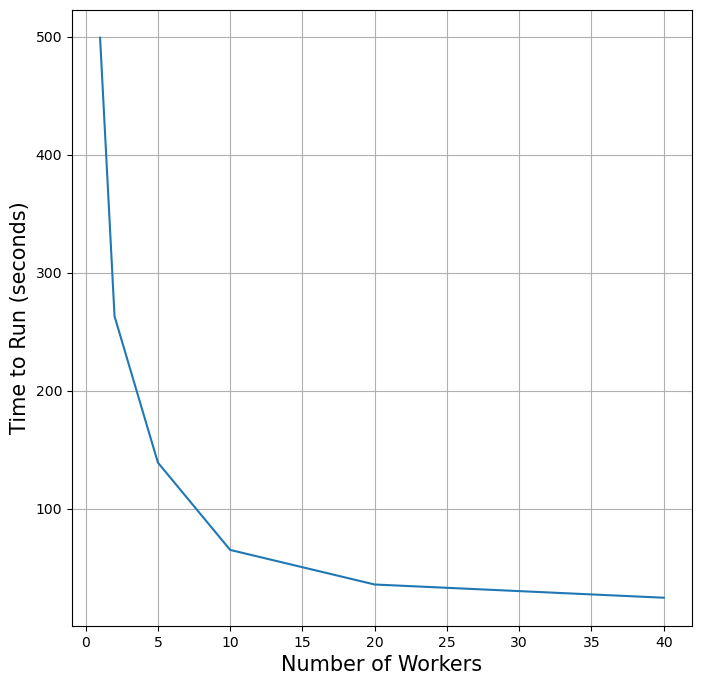

In [13]:
fit=plt.figure(figsize=(8,8))

plt.plot(workers,time_to_run)

plt.ylabel('Time to Run (seconds)',fontsize=15)
plt.xlabel('Number of Workers',fontsize=15)

plt.grid()
plt.show()
plt.close()

## What about larger datasets?

Larger datasets can easily be ingested into this function! The main control on computation time is the number of uniquely labeled storms that are being compared. So, for instance, a 1000x1000 grid with only 10 uniquely labeled storms would be much quicker to run than a 500x500 grid with 100 uniquely labeled storms. 

This relates back to the struct,rr,cc variables defined during the labeling step above. Testing is needed to determine optimal values for different grids.

### Output from tracking on a 24 (time) x 899 (south_north) x 1399 (east_west) grid

This took about 4 minutes to run on 20 workers with 1 thread each.

<img src="img/tracking.gif" alt="Tracked Storms"/>

## Important Note

The above figure highlights the need for effective testing before running this algorithm. The labeling is inconsistent and storms that are separate from each other get merged and broken apart, resulting in unrealistic labeling. A lot of testing on optimal parameters is needed before tracking storms. In particular, the similarity constant (tau) and the structure of the array used within the labeling function can significantly impact the result.

## Conclusions

Overall, the changes presented here drastically reduce computation time and the amount of memory needed to perform those computations. This function is now much more scalable, and if time is not much of an issue, can even be run on a local computer with limited cores and memory!